# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.

KeyboardInterrupt: 

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_inputs")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Images: 28 * 28
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        h1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding="same")
        h1 = tf.maximum(h1, alpha * h1)
        # 14 * 14
        
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding="same")
        h2 = tf.layers.batch_normalization(h2, training=training)
        h2 = tf.layers.dropout(h2, rate=0.2, training=training)
        h2 = tf.maximum(h2, alpha * h2)
        # 7 * 7
        
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding="same")
        h3 = tf.layers.batch_normalization(h3, training=training)        
        h3 = tf.layers.dropout(h3, rate=0.3, training=training)
        h3 = tf.maximum(h3, alpha * h3)
        # 4 * 4
        
        h4 = tf.layers.conv2d(h3, filters=512, kernel_size=4, strides=2, padding="same")
        h4 = tf.layers.batch_normalization(h4, training=training)
        h4 = tf.layers.dropout(h4, rate=0.4, training=training)
        h4 = tf.maximum(h4, alpha*h4)
        # 2 * 2
        
        flattened = tf.reshape(h4, (-1, 2*2*512))
        logits = tf.layers.dense(flattened, units=1)
        output = tf.nn.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse=not is_train):
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(h1, alpha * h1)
        # 2 * 2
        
        h2 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=5, strides=2, padding="valid")
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(h2, alpha * h2)
        # 4 * 4
        
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding="same")
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(h3, alpha * h3)
        # 8 * 8
        
        logits = tf.layers.conv2d_transpose(h3, filters=out_channel_dim, kernel_size=5, strides=2, padding="same")
        output = tf.tanh(logits)
        
    # TODO: Implement Function
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing_factor = 0.1
    
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logit_fake = discriminator(g_out)
    d_out_real, d_logit_real = discriminator(input_real, reuse=True)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)
                                ))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits=d_logit_real, labels=tf.ones_like(d_logit_real) * (1 - smoothing_factor)
                                ))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)
                            ))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        d_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    n_img_to_display = 25
    losses = []
    iteration = 0   
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                iteration += 1
                batch_images *= 2
                z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input: z, lr: learning_rate})
                
                
                if iteration % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z, real_input: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if iteration % show_every == 0:
                    show_generator_output(sess, n_img_to_display, z_input, img_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0401... Generator Loss: 3.7697
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.4757
Epoch 1/2... Discriminator Loss: 0.0164... Generator Loss: 4.4289
Epoch 1/2... Discriminator Loss: 0.1349... Generator Loss: 2.1854
Epoch 1/2... Discriminator Loss: 3.2177... Generator Loss: 0.0435
Epoch 1/2... Discriminator Loss: 0.0570... Generator Loss: 3.5282
Epoch 1/2... Discriminator Loss: 1.5329... Generator Loss: 7.4293
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.6025... Generator Loss: 0.2790
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 0.7693


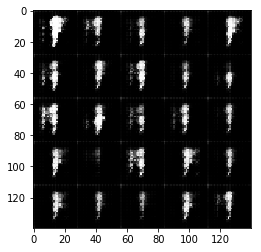

Epoch 1/2... Discriminator Loss: 1.8219... Generator Loss: 6.3040
Epoch 1/2... Discriminator Loss: 0.1178... Generator Loss: 4.4462
Epoch 1/2... Discriminator Loss: 7.2176... Generator Loss: 14.4626
Epoch 1/2... Discriminator Loss: 0.3024... Generator Loss: 4.8206
Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 2.2572
Epoch 1/2... Discriminator Loss: 0.1402... Generator Loss: 3.2940
Epoch 1/2... Discriminator Loss: 0.1684... Generator Loss: 2.3758
Epoch 1/2... Discriminator Loss: 0.0424... Generator Loss: 3.3387
Epoch 1/2... Discriminator Loss: 0.2555... Generator Loss: 9.4343
Epoch 1/2... Discriminator Loss: 0.0124... Generator Loss: 7.2852


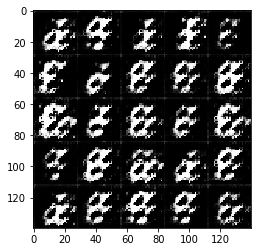

Epoch 1/2... Discriminator Loss: 3.6631... Generator Loss: 0.0314
Epoch 1/2... Discriminator Loss: 0.2192... Generator Loss: 2.4181
Epoch 1/2... Discriminator Loss: 0.2249... Generator Loss: 2.2086
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 1.6376
Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 1.6504
Epoch 1/2... Discriminator Loss: 0.2512... Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 0.2766... Generator Loss: 2.4894
Epoch 1/2... Discriminator Loss: 0.2345... Generator Loss: 2.0413
Epoch 1/2... Discriminator Loss: 0.1452... Generator Loss: 2.5471
Epoch 1/2... Discriminator Loss: 0.2170... Generator Loss: 2.2728


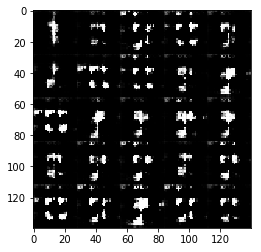

Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 6.8220
Epoch 1/2... Discriminator Loss: 0.2338... Generator Loss: 4.5175
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 1.9078
Epoch 1/2... Discriminator Loss: 0.2933... Generator Loss: 2.4622
Epoch 1/2... Discriminator Loss: 0.1041... Generator Loss: 2.8361
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 1.3286
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 2.8467
Epoch 1/2... Discriminator Loss: 0.3743... Generator Loss: 1.9964
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 3.1235


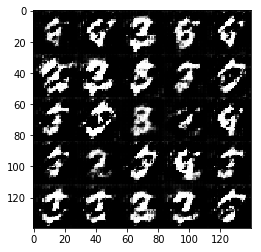

Epoch 1/2... Discriminator Loss: 0.2635... Generator Loss: 3.2685
Epoch 1/2... Discriminator Loss: 0.2885... Generator Loss: 2.7129
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 0.2381... Generator Loss: 2.0417
Epoch 1/2... Discriminator Loss: 0.4252... Generator Loss: 1.6074
Epoch 2/2... Discriminator Loss: 0.4092... Generator Loss: 1.9912
Epoch 2/2... Discriminator Loss: 0.4605... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 8.2104
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.2719


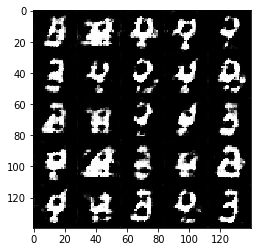

Epoch 2/2... Discriminator Loss: 0.5032... Generator Loss: 1.7518
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 1.2405
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 1.8564
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 0.2556... Generator Loss: 2.4678
Epoch 2/2... Discriminator Loss: 0.3954... Generator Loss: 2.1775
Epoch 2/2... Discriminator Loss: 0.3593... Generator Loss: 2.1252
Epoch 2/2... Discriminator Loss: 0.2726... Generator Loss: 2.2038
Epoch 2/2... Discriminator Loss: 0.2273... Generator Loss: 2.4137
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 3.3083


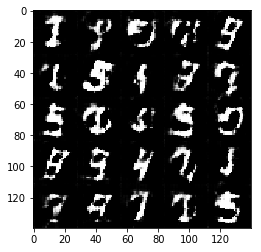

Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.4959
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 3.8544
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 0.4770... Generator Loss: 2.0484
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 2.2738
Epoch 2/2... Discriminator Loss: 1.8975... Generator Loss: 0.2509


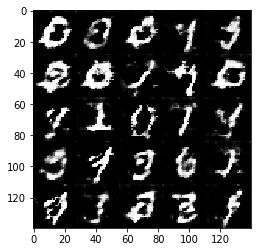

Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 2.7242
Epoch 2/2... Discriminator Loss: 3.1923... Generator Loss: 8.0458
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 2.0002
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 1.9162
Epoch 2/2... Discriminator Loss: 0.4847... Generator Loss: 2.5117
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 2.5029
Epoch 2/2... Discriminator Loss: 0.4799... Generator Loss: 3.2816
Epoch 2/2... Discriminator Loss: 0.4767... Generator Loss: 1.7272


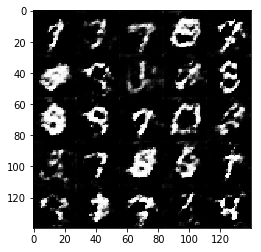

Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.4579
Epoch 2/2... Discriminator Loss: 0.3901... Generator Loss: 2.0488
Epoch 2/2... Discriminator Loss: 0.2442... Generator Loss: 3.0475
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.9248
Epoch 2/2... Discriminator Loss: 0.5762... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 0.4882... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.3601... Generator Loss: 2.1272
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 1.7761


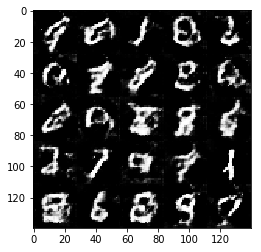

Epoch 2/2... Discriminator Loss: 0.4057... Generator Loss: 1.6855
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.8873... Generator Loss: 0.2797


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.2971
Epoch 1/2... Discriminator Loss: 1.9426... Generator Loss: 0.2203
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 3.9079
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 2.9277
Epoch 1/2... Discriminator Loss: 0.1663... Generator Loss: 2.1743
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 2.1658... Generator Loss: 3.4392
Epoch 1/2... Discriminator Loss: 0.6664... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 4.7921


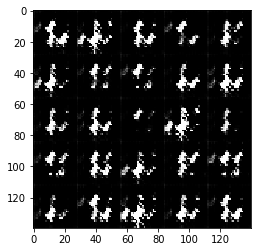

Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 2.1489
Epoch 1/2... Discriminator Loss: 4.5223... Generator Loss: 0.0153
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 1.4043
Epoch 1/2... Discriminator Loss: 0.3718... Generator Loss: 1.9679
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 1.7302
Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 5.1257
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 4.4070


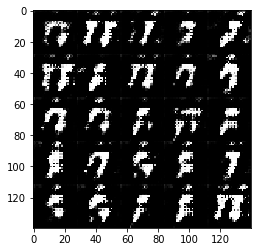

Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.6086
Epoch 1/2... Discriminator Loss: 0.2690... Generator Loss: 3.0061
Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 1.3536
Epoch 2/2... Discriminator Loss: 0.2870... Generator Loss: 3.3449
Epoch 2/2... Discriminator Loss: 0.1763... Generator Loss: 3.1778
Epoch 2/2... Discriminator Loss: 0.1221... Generator Loss: 3.1733
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 3.2333
Epoch 2/2... Discriminator Loss: 0.3413... Generator Loss: 2.2033
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 1.5872... Generator Loss: 5.5354


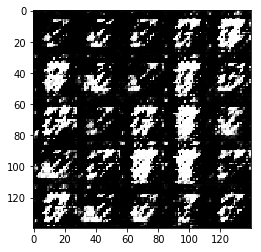

Epoch 2/2... Discriminator Loss: 0.3072... Generator Loss: 1.9357
Epoch 2/2... Discriminator Loss: 0.2419... Generator Loss: 2.1553
Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 3.4795
Epoch 2/2... Discriminator Loss: 0.1272... Generator Loss: 2.6939
Epoch 2/2... Discriminator Loss: 0.1607... Generator Loss: 2.6492
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 0.2504... Generator Loss: 2.1313
Epoch 2/2... Discriminator Loss: 0.4983... Generator Loss: 1.5933
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 2.1003
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.5000


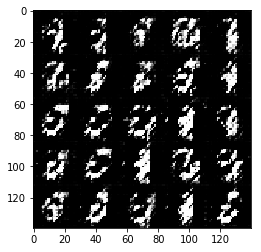

Epoch 2/2... Discriminator Loss: 1.7620... Generator Loss: 6.3629
Epoch 2/2... Discriminator Loss: 1.5970... Generator Loss: 0.2905
Epoch 2/2... Discriminator Loss: 0.2061... Generator Loss: 2.5159
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.6859
Epoch 2/2... Discriminator Loss: 2.5689... Generator Loss: 0.1283
Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.5598


In [16]:
batch_size = 256
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.2757... Generator Loss: 1.7533
Epoch 1/2... Discriminator Loss: 0.0263... Generator Loss: 5.2927
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.5657
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 6.0982
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 1.4886
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 2.3185
Epoch 1/2... Discriminator Loss: 0.1922... Generator Loss: 3.6488
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 1.5678
Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 4.5455... Generator Loss: 0.0223


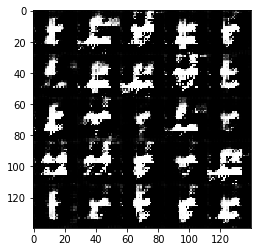

Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 2.2819... Generator Loss: 0.1910
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 1.4750
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.4517
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 0.8625
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 3.3949
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 1.9740
Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 1.6758


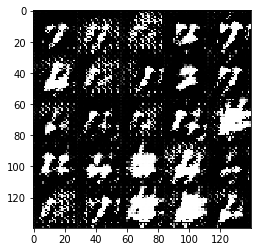

Epoch 1/2... Discriminator Loss: 0.1753... Generator Loss: 2.2675
Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 0.4902
Epoch 1/2... Discriminator Loss: 5.1464... Generator Loss: 7.8349
Epoch 1/2... Discriminator Loss: 0.6075... Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 2.3554
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 0.2309... Generator Loss: 3.9280
Epoch 1/2... Discriminator Loss: 1.7615... Generator Loss: 0.2633
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.5169


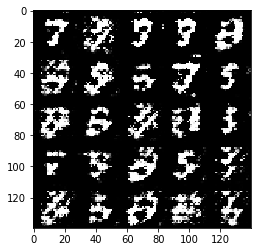

Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 1.5642
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 4.0345
Epoch 1/2... Discriminator Loss: 0.2702... Generator Loss: 2.3821
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 3.9953
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 0.4198... Generator Loss: 2.0150
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 2.7501
Epoch 1/2... Discriminator Loss: 0.3547... Generator Loss: 1.3410
Epoch 1/2... Discriminator Loss: 0.2044... Generator Loss: 2.3606


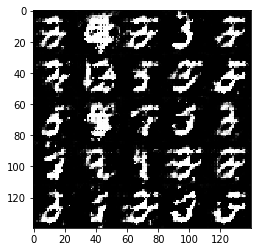

Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 3.8429
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 3.3055
Epoch 1/2... Discriminator Loss: 2.7112... Generator Loss: 3.8082
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.4580
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.7587... Generator Loss: 0.2994
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 3.3855
Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 1.0613


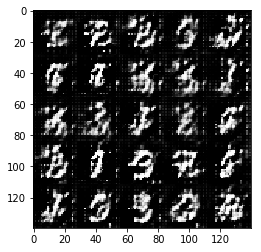

Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 1.2936
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 3.1626
Epoch 1/2... Discriminator Loss: 1.8391... Generator Loss: 0.3241
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 3.3297
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 1.3510
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 3.7910
Epoch 1/2... Discriminator Loss: 1.6905... Generator Loss: 0.2626
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.6307


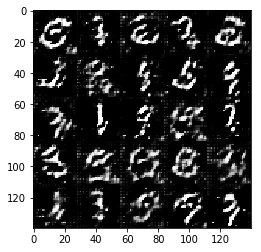

Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 1.9329
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 0.2024... Generator Loss: 3.2947
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.4598
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 1.1774
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.3702
Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 2.7822
Epoch 1/2... Discriminator Loss: 0.6215... Generator Loss: 2.4219
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 2.0924
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.4727


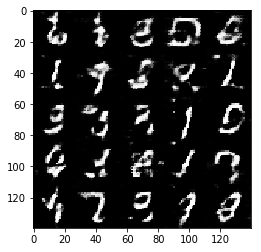

Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 1.7448
Epoch 1/2... Discriminator Loss: 0.2556... Generator Loss: 2.8510
Epoch 1/2... Discriminator Loss: 1.5737... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.3717
Epoch 1/2... Discriminator Loss: 1.5727... Generator Loss: 5.1530
Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 2.5264
Epoch 1/2... Discriminator Loss: 0.5345... Generator Loss: 1.3028
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 2.2274


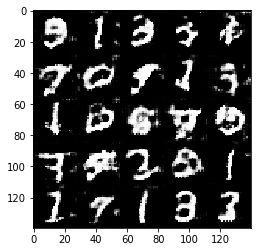

Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 2.8088
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 2.2892... Generator Loss: 0.1646
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 3.5479
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 8.3052
Epoch 1/2... Discriminator Loss: 2.5283... Generator Loss: 0.1207
Epoch 1/2... Discriminator Loss: 0.4978... Generator Loss: 1.5800
Epoch 1/2... Discriminator Loss: 1.5200... Generator Loss: 0.3637


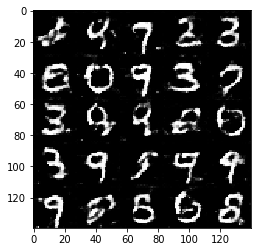

Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 2.0129... Generator Loss: 2.3941
Epoch 1/2... Discriminator Loss: 3.2414... Generator Loss: 0.0713
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.6994
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.3809
Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.3708
Epoch 2/2... Discriminator Loss: 2.8967... Generator Loss: 0.0861
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 2.2661... Generator Loss: 0.2162


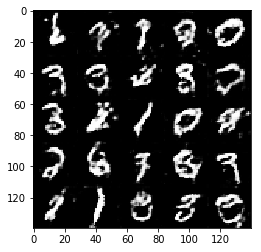

Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 2.7440
Epoch 2/2... Discriminator Loss: 0.6187... Generator Loss: 1.4191
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 0.4564... Generator Loss: 2.2111
Epoch 2/2... Discriminator Loss: 1.9029... Generator Loss: 3.8716
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.2385... Generator Loss: 3.4517
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 3.6712
Epoch 2/2... Discriminator Loss: 2.2741... Generator Loss: 0.1784
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.6650


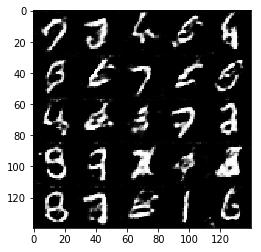

Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 2.4546
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.3009
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 2.6610
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.1870
Epoch 2/2... Discriminator Loss: 0.5395... Generator Loss: 1.3613
Epoch 2/2... Discriminator Loss: 1.6273... Generator Loss: 0.3564
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 4.9002... Generator Loss: 0.8934


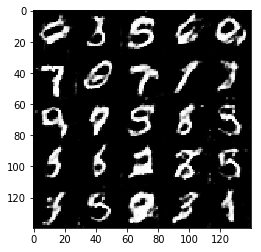

Epoch 2/2... Discriminator Loss: 1.6127... Generator Loss: 0.4253
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 2.1325... Generator Loss: 0.2214
Epoch 2/2... Discriminator Loss: 2.7794... Generator Loss: 0.1148
Epoch 2/2... Discriminator Loss: 1.8392... Generator Loss: 0.2631
Epoch 2/2... Discriminator Loss: 2.6201... Generator Loss: 0.1644
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 1.7426
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 0.7950


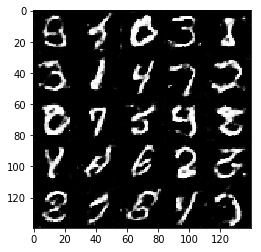

Epoch 2/2... Discriminator Loss: 1.9440... Generator Loss: 0.2468
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.4642
Epoch 2/2... Discriminator Loss: 2.0018... Generator Loss: 0.2228
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.5880
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.3938
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 0.8392... Generator Loss: 2.5891
Epoch 2/2... Discriminator Loss: 1.5661... Generator Loss: 0.3577


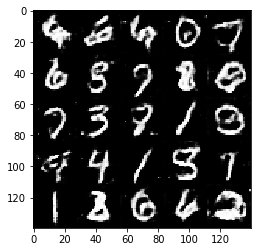

Epoch 2/2... Discriminator Loss: 1.8481... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.3434
Epoch 2/2... Discriminator Loss: 1.6039... Generator Loss: 0.3829
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.2682
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 2.4969
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.5416


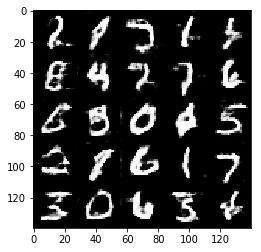

Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.3670
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 2.3107
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 1.9809... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.5652
Epoch 2/2... Discriminator Loss: 2.5913... Generator Loss: 0.1119
Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.3419


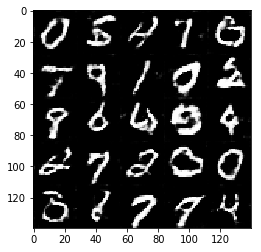

Epoch 2/2... Discriminator Loss: 1.7757... Generator Loss: 0.2964
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.8874
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 2.4602
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.3626
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 3.6935
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 3.9360
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.6470


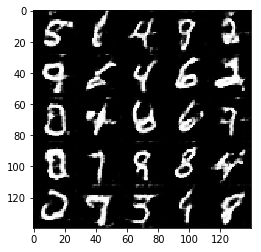

Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 0.6529
Epoch 2/2... Discriminator Loss: 1.4692... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 1.5038... Generator Loss: 0.3715
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 2.4887... Generator Loss: 7.8624
Epoch 2/2... Discriminator Loss: 2.2583... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 0.4980... Generator Loss: 2.0202
Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.2546
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 0.8008


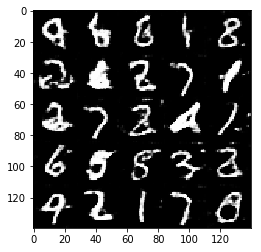

Epoch 2/2... Discriminator Loss: 0.7415... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 1.6559
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 5.5566
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 3.2034... Generator Loss: 4.4760


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2550... Generator Loss: 3.3686
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 2.5449
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 2.5751
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 0.8067


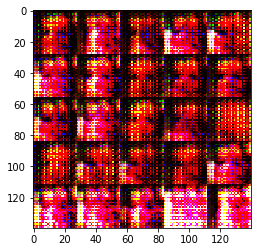

Epoch 1/1... Discriminator Loss: 6.1745... Generator Loss: 7.6447
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 4.0373
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 3.3964
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 5.4076
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 4.2687
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 4.0409
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 4.8443


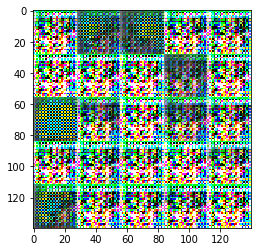

Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 4.1556
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 4.2176
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 3.0038
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 3.2557
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 0.2887... Generator Loss: 5.4812
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 2.1097... Generator Loss: 4.4076
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.5368


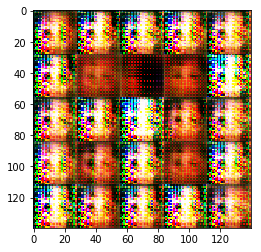

Epoch 1/1... Discriminator Loss: 1.8593... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 1.9547
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 3.5764
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 0.1622... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 1.6790


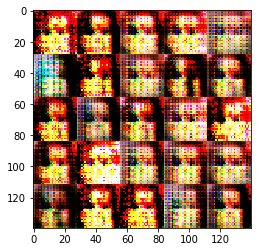

Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 3.5294
Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 1.9263
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 2.8045
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 2.9970


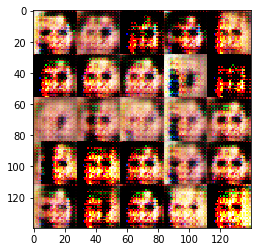

Epoch 1/1... Discriminator Loss: 0.2185... Generator Loss: 3.1146
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 3.8887
Epoch 1/1... Discriminator Loss: 0.2734... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 4.9216
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.4716


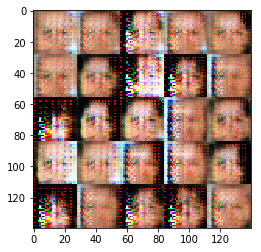

Epoch 1/1... Discriminator Loss: 0.1143... Generator Loss: 2.6406
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 1.9175
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 2.1844
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 2.0868
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 2.2615
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 2.2215


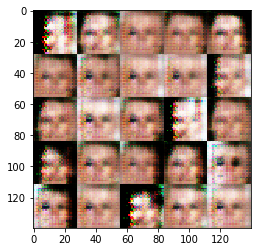

Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.0090
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 4.6537
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 3.1734
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 2.8176
Epoch 1/1... Discriminator Loss: 0.2623... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 3.9517
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 4.5123
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 5.8047


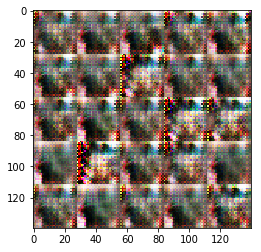

Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 3.3566
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.0767
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 4.1226
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 5.0565
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 3.3588
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 3.4284
Epoch 1/1... Discriminator Loss: 5.0395... Generator Loss: 6.6237
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 4.5492... Generator Loss: 6.7039
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.3167


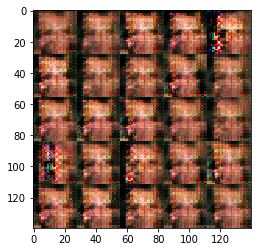

Epoch 1/1... Discriminator Loss: 1.9870... Generator Loss: 7.1419
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 3.2873
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 2.4099
Epoch 1/1... Discriminator Loss: 5.3600... Generator Loss: 7.2749
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 2.1073
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 2.2371
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 0.7682


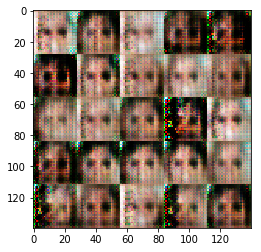

Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 2.7658
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.5724
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 2.7463
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 2.3423
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.4532


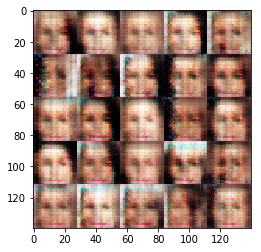

Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 2.8865
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.7336


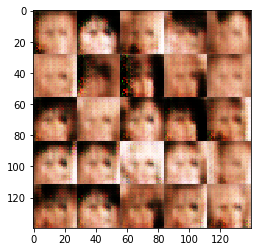

Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 2.6491
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 2.8319
Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 2.7005
Epoch 1/1... Discriminator Loss: 1.7314... Generator Loss: 0.2473
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 2.6464
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 3.0493... Generator Loss: 3.9133


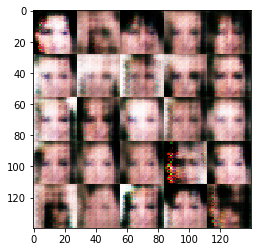

Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 4.7271
Epoch 1/1... Discriminator Loss: 2.2633... Generator Loss: 3.3450
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 1.2388


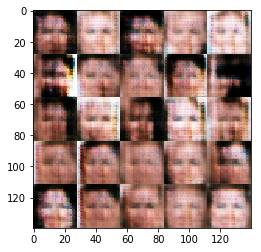

Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 4.8042... Generator Loss: 0.0111
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 3.0154
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 3.1018
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.9953


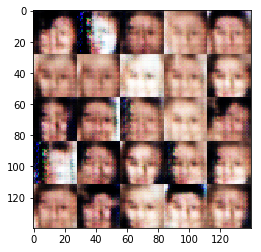

Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 3.6427
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.6227
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 1.5474
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.9803
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 2.9354
Epoch 1/1... Discriminator Loss: 3.1256... Generator Loss: 4.6589
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.3258


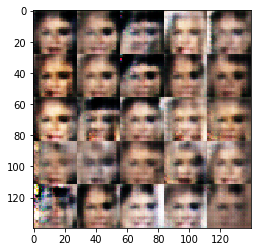

Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.9009
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 3.4592... Generator Loss: 0.0459
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.4762
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 2.1955
Epoch 1/1... Discriminator Loss: 0.1695... Generator Loss: 2.1659
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.3461


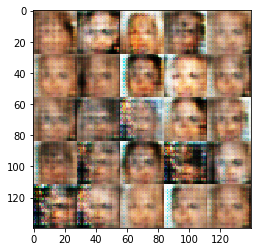

Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.8910... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 1.9571
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 2.3020... Generator Loss: 2.7686
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 0.9630


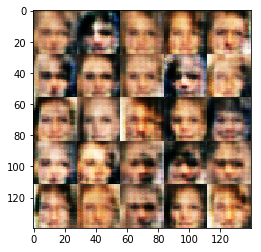

Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 2.2471
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 2.4387
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 2.5490
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.8197


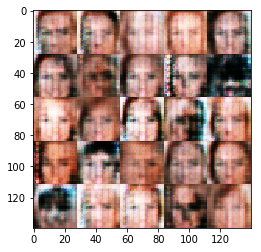

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.6425
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 1.8141... Generator Loss: 0.2821
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 3.6806
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 4.6192
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.3621


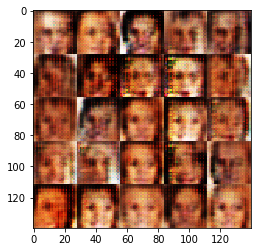

Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.8666


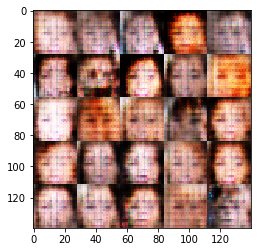

Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.8259... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.9332


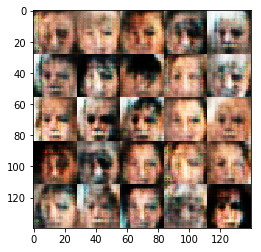

Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 2.3932
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.9886
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.2774


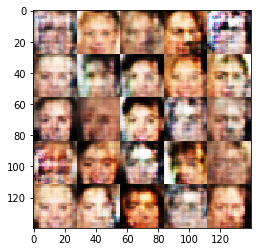

Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 0.2342... Generator Loss: 3.0072
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 2.6192
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 2.5239
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 0.3066... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 0.7281


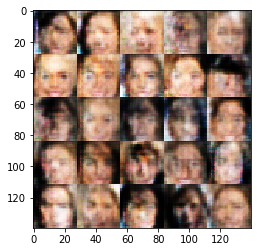

Epoch 1/1... Discriminator Loss: 0.2522... Generator Loss: 1.9310
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 0.3107... Generator Loss: 2.7307
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 1.9350
Epoch 1/1... Discriminator Loss: 3.5624... Generator Loss: 0.0414
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 2.9237
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 2.9013


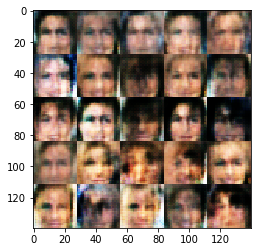

Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 1.9111
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 2.0050
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 3.1084
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.6164... Generator Loss: 2.2184
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 1.2987


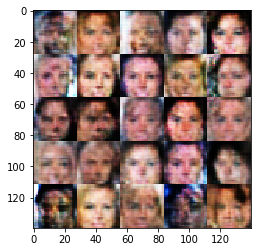

Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.5540
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 3.5127
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 0.7481


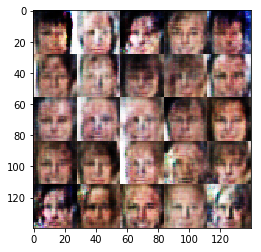

Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.7173
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.8201... Generator Loss: 0.2446
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 2.3810
Epoch 1/1... Discriminator Loss: 0.0919... Generator Loss: 2.9651
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 2.4995... Generator Loss: 4.2669
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.6974


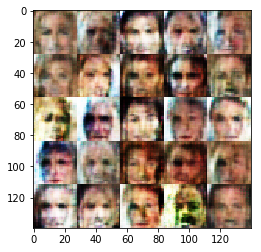

Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 3.5987
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 2.7713
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 1.5487
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 2.5040
Epoch 1/1... Discriminator Loss: 0.2140... Generator Loss: 2.4990
Epoch 1/1... Discriminator Loss: 2.1710... Generator Loss: 0.2431


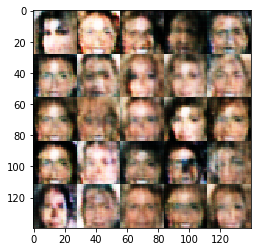

Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 2.3566
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.2768
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 2.0712
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 1.2012
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 1.8854


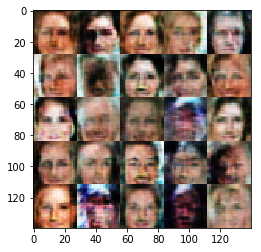

Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.6852... Generator Loss: 0.2441
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.2899
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 4.8063
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 0.1587... Generator Loss: 2.7157
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 0.6982


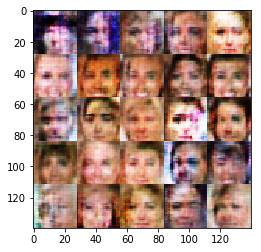

Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 2.5310
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.2577... Generator Loss: 1.7145
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 5.4591
Epoch 1/1... Discriminator Loss: 7.0311... Generator Loss: 6.8070
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 2.3244


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 2.7537... Generator Loss: 5.4943
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.9664
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.2347
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 0.1604... Generator Loss: 2.7462
Epoch 1/1... Discriminator Loss: 2.0965... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.4150
Epoch 1/1... Discriminator Loss: 0.2133... Generator Loss: 2.6240


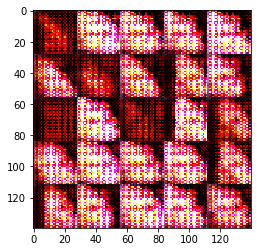

Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 0.2065... Generator Loss: 3.3979
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 1.8438
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 2.4623
Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 2.4095
Epoch 1/1... Discriminator Loss: 0.2146... Generator Loss: 2.4939
Epoch 1/1... Discriminator Loss: 0.2581... Generator Loss: 1.6773
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 3.1880


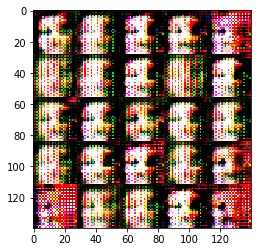

Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 2.6271
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 4.9333
Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 3.3491
Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 4.8742
Epoch 1/1... Discriminator Loss: 0.0747... Generator Loss: 2.9475
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 5.2239
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 0.2528... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.8902


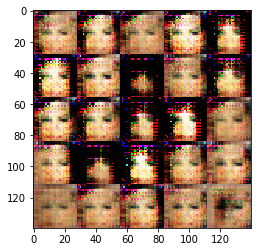

Epoch 1/1... Discriminator Loss: 0.1683... Generator Loss: 2.3875
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 1.6935
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 1.6739... Generator Loss: 4.1503
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 4.6093
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 4.0330
Epoch 1/1... Discriminator Loss: 2.8866... Generator Loss: 0.1110
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8758


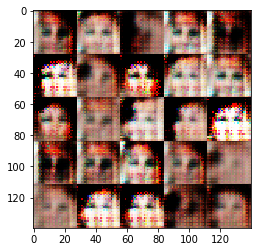

Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.6882... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8699


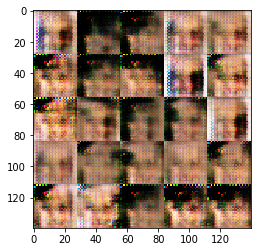

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 2.4312
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.9211


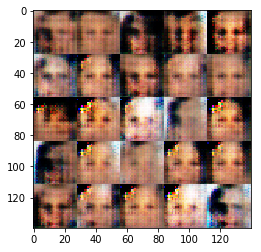

Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6278


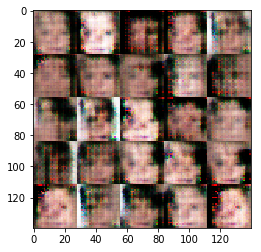

Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 2.4961
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 2.2029... Generator Loss: 0.1720
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.4816


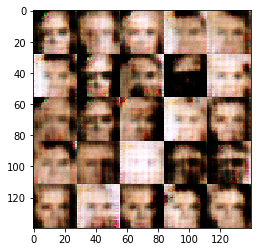

Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 3.0076
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.7267
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.9420... Generator Loss: 2.9487
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 2.7804
Epoch 1/1... Discriminator Loss: 2.0131... Generator Loss: 0.1980
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.5836


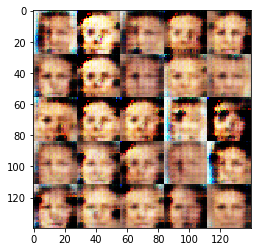

Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.4542
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.6883


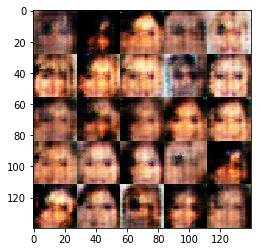

Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.7607


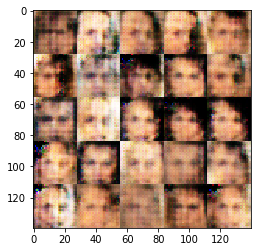

Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 1.9223
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.4382
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.7162
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.1113


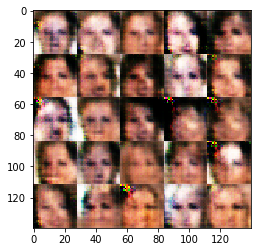

Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.0224


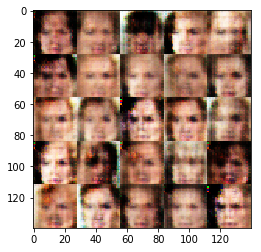

Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 2.1168
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.9548
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 0.8080


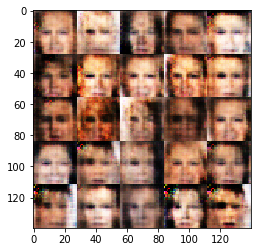

Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.8139
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 2.0285


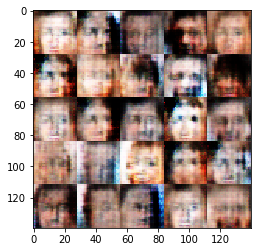

Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 2.0502
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 3.1850
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 2.7561


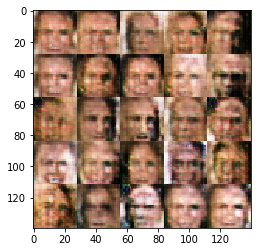

Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 2.9265... Generator Loss: 3.6342
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.4184
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 2.0532
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 2.4550... Generator Loss: 0.1324
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.4018


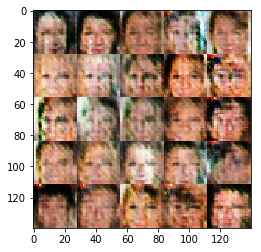

Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 2.3244
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 1.7972... Generator Loss: 0.2702
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.4406


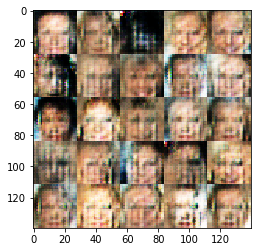

Epoch 1/1... Discriminator Loss: 2.3243... Generator Loss: 2.8006
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 2.6235... Generator Loss: 4.4015
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.1663


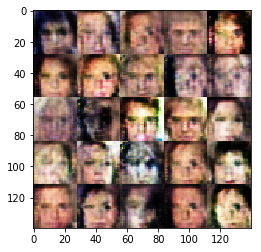

Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.3475
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.7836
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.3131


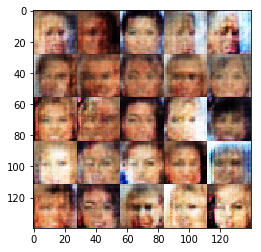

Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 1.9209


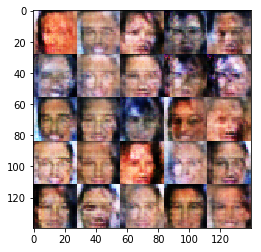

Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 2.4248
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 2.3564
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.1398


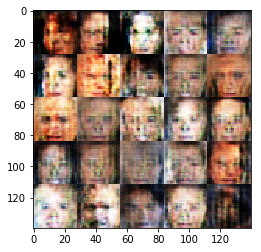

Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 1.8125... Generator Loss: 0.2400
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 2.2188... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 3.4961
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 1.9056... Generator Loss: 0.2058
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 2.2213
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.2077


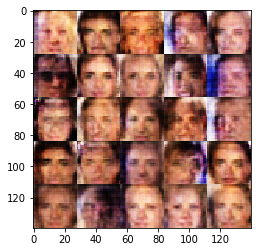

Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.4834
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.9015... Generator Loss: 0.2278
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.7700... Generator Loss: 0.2890
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.6905
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 1.5104


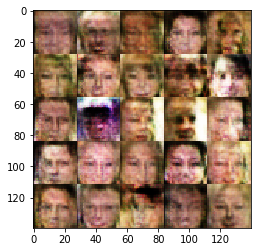

Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 2.2285
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 1.6954... Generator Loss: 3.0055
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 1.7427... Generator Loss: 0.2550
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 0.9389


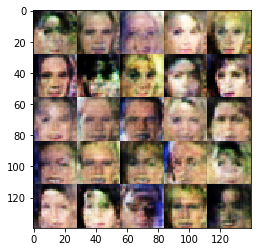

Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.3934
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 2.0745
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.7479
Epoch 1/1... Discriminator Loss: 2.3707... Generator Loss: 0.1507
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 2.0571


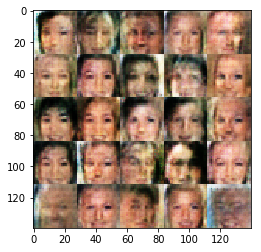

Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 2.1246
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 2.7120
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.4227


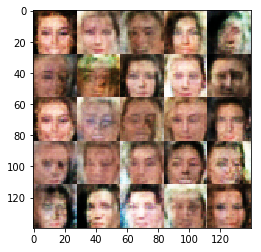

Epoch 1/1... Discriminator Loss: 2.0128... Generator Loss: 0.2464
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.9975
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 2.1956
Epoch 1/1... Discriminator Loss: 1.7580... Generator Loss: 0.2613
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 1.6142
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7715


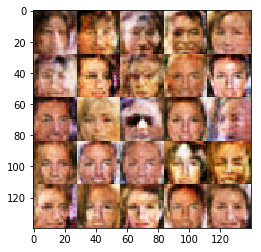

Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 3.2203
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 3.1121
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 2.4892
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 2.9058


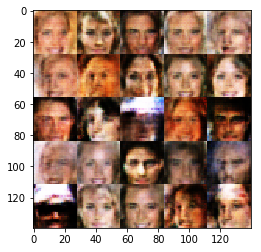

Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 2.4640
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.9376... Generator Loss: 0.2183
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.5574


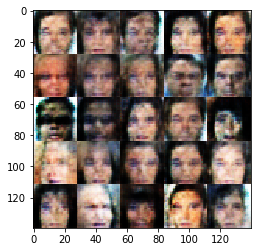

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 2.0305... Generator Loss: 0.2181
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.6865
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.4535


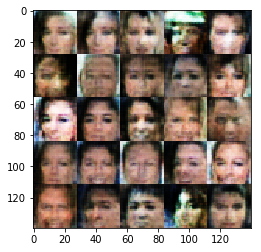

Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 2.0911
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.2629


In [22]:
batch_size = 64
z_dim = 128
learning_rate = 0.003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 10.2896
Epoch 1/1... Discriminator Loss: 0.2260... Generator Loss: 2.0118
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 3.8840
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.2853
Epoch 1/1... Discriminator Loss: 0.0433... Generator Loss: 4.6498
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 5.7445
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 14.5290
Epoch 1/1... Discriminator Loss: 0.2009... Generator Loss: 2.6505


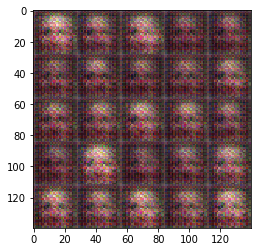

Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 3.3401... Generator Loss: 11.3071
Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 5.2997
Epoch 1/1... Discriminator Loss: 0.2973... Generator Loss: 2.2151
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 2.7573
Epoch 1/1... Discriminator Loss: 0.2406... Generator Loss: 4.8965
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 2.1667
Epoch 1/1... Discriminator Loss: 0.2760... Generator Loss: 2.9437
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 3.5518


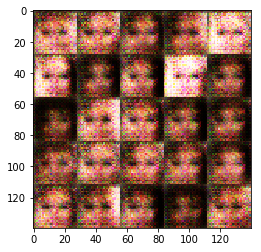

Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 2.0676
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 1.7835
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 2.2270
Epoch 1/1... Discriminator Loss: 0.2826... Generator Loss: 1.9869
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 3.4193
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 2.0105... Generator Loss: 7.1893
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 3.3815


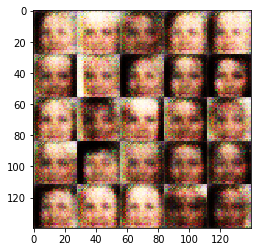

Epoch 1/1... Discriminator Loss: 0.3035... Generator Loss: 3.1481
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.3439
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 1.8202
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.2646... Generator Loss: 2.8107
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 2.2584
Epoch 1/1... Discriminator Loss: 0.3147... Generator Loss: 2.8852
Epoch 1/1... Discriminator Loss: 0.1753... Generator Loss: 3.8045
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.1584


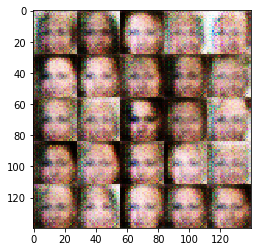

Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 2.4339
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.5972
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.4139


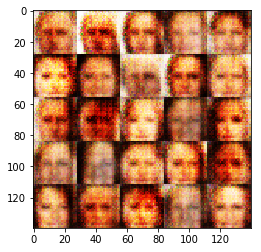

Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.9088
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.2993
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 1.8344
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.0938


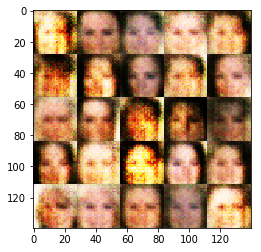

Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.8506
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.5500
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 3.0141
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.8557


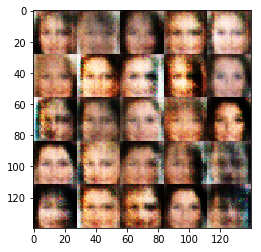

Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.9637
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 2.0472
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 2.7000
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.1435


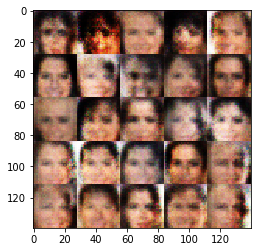

Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.6821
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.3877


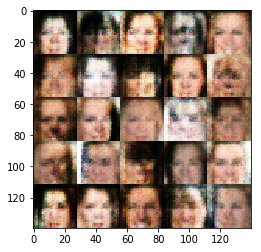

Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 0.9608


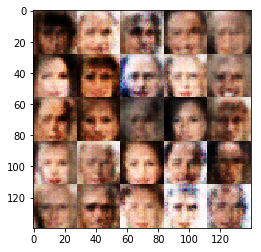

Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.9002
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 1.7236
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.5104


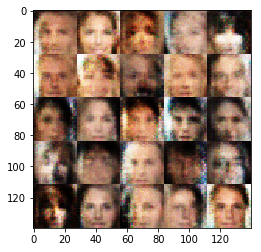

Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 2.2875
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 2.1780
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 2.1278
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.7406
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 0.8106


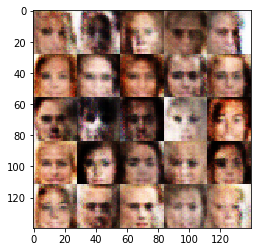

Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.5978


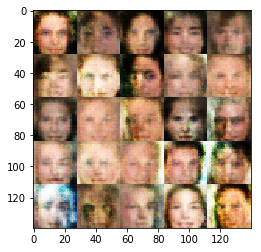

Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 2.1382
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.7793
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.8730
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.2378


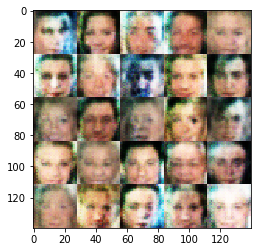

Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 2.1850
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.8272
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.8010
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 1.6042
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.4648


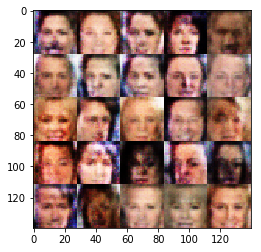

Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 2.2073
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 2.1812
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.9511


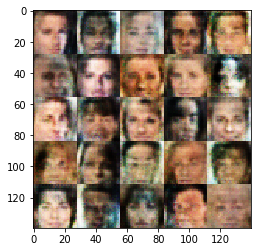

Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 1.6496
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 2.5153
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.7051


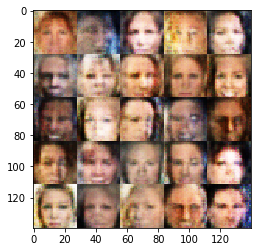

Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.6752
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 2.0074
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 0.9306


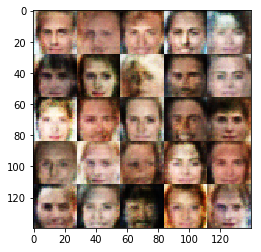

Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 1.7456
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 2.4389
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.0852


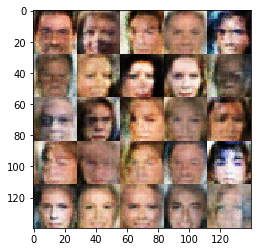

Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.2898


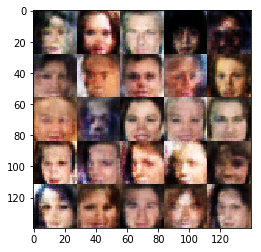

Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.8847
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 2.2862
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.7038


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.